In [2]:
import pertpy as pt
import scanpy as sc
from scvi import REGISTRY_KEYS

In [3]:
import random
import numpy as np
import torch
import os
import sklearn

def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
adata = sc.read_h5ad('../data/PBMC_yale.h5ad')
adata = adata[adata.obs['perturbation'].isin(['No stimulation','IFNb']),:].copy()

In [5]:
pt.tl.Scgen.setup_anndata(adata, batch_key='perturbation', labels_key='cell_type0528')

In [6]:
scgen_model = pt.tl.Scgen(adata)

In [7]:
scgen_model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    accelerator="cpu",
)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Monitored metric elbo_validation did not improve in the last 25 records. Best score: 767.125. Signaling Trainer to stop.


In [8]:
scgen_model.save("./scgen/model_perturbation_prediction.pt", overwrite=True)

In [9]:
latent_X = scgen_model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())

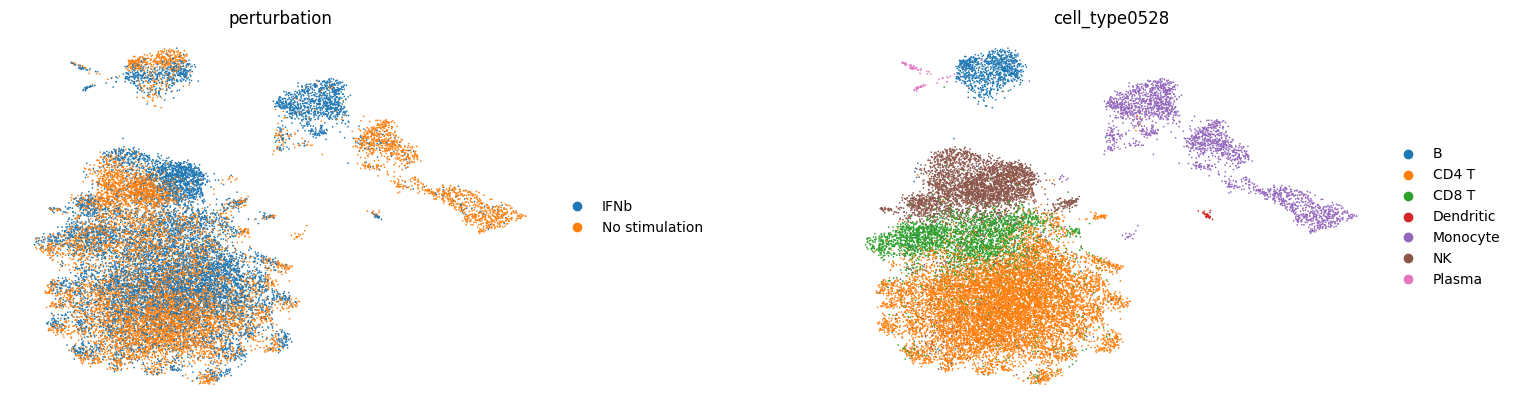

In [10]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(
    latent_adata,
    color=['perturbation', 'cell_type0528'],
    wspace=0.4,
    frameon=False
)

In [ ]:
import rpy2.robjects as robjects

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()


import anndata2ri
anndata2ri.activate()
# Add your library path
library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
# Update R's library paths
robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
# Verify the updated library paths
print(robjects.r('.libPaths()'))

anndata2ri.activate()
%load_ext rpy2.ipython

latent_adata.obsm["latent"]=latent_X

from metrics import calculate_metrics

try:
    calculate_metrics(latent_adata, batch_key='perturbation', celltype_key='cell_type0528', all=True, n_neighbors=15,
                          embed='latent', savepath="./scgen/" + "PBMC_yale" + ".csv")
except:
    calculate_metrics(latent_adata, batch_key='perturbation', celltype_key='cell_type0528', all=True, n_neighbors=15,
                          embed='latent', savepath="./scgen/" + "PBMC_yale" + ".csv")

['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']
R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


LISI---
cLISI, bLISI, LISI_F1 0.9627410048967381 0.4380093250492572 0.6020909347468392
ASW---
asw_label 0.5317033901810646
asw_batch 0.9126343313773245
kBET---
0 labels consist of a single batch or is too small. Skip.
kbet_score 0.38927032414931884
graph_conn 0.9947217563437751
NMI, ARI ---
NMI 0.6598100566351625
ARI 0.6813583977937715
positive and true positive rate---


In [ ]:
def run_scgen(adata, condition_key, cell_type_key,exp_label, ref_label, dataset_name):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    adata=adata.copy()
    
    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]].copy()
    
    pt.tl.Scgen.setup_anndata(adata, batch_key=condition_key, labels_key=cell_type_key)
    scgen_model = pt.tl.Scgen(adata)

    scgen_model.train(
        max_epochs=100,
        batch_size=32,
        early_stopping=True,
        early_stopping_patience=25,
        #accelerator="cpu",
    )

    scgen_model.save("./scgen/"+dataset_name+".pt", overwrite=True)

    latent_X = scgen_model.get_latent_representation()
    latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())
    latent_adata.obsm["latent"]=latent_X

    sc.pp.neighbors(latent_adata)
    sc.tl.umap(latent_adata)
    sc.pl.umap(
        latent_adata,
        color=[condition_key, cell_type_key],
        wspace=0.4,
        frameon=False
    )
    latent_adata.write("./scgen/" + dataset_name + ".h5ad")

    import rpy2.robjects as robjects
    import os
    os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
    import anndata2ri
    anndata2ri.activate()

    from metrics import calculate_metrics

    try:
        calculate_metrics(latent_adata, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='latent', savepath="./scgen/" + dataset_name + ".csv")
    except:
        calculate_metrics(latent_adata, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='latent', savepath="./scgen/" + dataset_name + ".csv")

# PBMC (yale)

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC_yale_preprocessed.h5ad')
run_scgen(adata=adata, condition_key='perturbation', cell_type_key='cell_type0528', exp_label='IFNb', ref_label='No stimulation', dataset_name="PBMC_yale")

# PBMC

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583

https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

adata = sc.read_h5ad('../data/PBMC.h5ad')
run_scgen(adata=adata, condition_key='condition', cell_type_key='cell_type', exp_label='stimulated', ref_label='control', dataset_name="PBMC")

# The Rhinovirus infection dataset

https://datadryad.org/stash/dataset/doi:10.5061/dryad.4xgxd25g1

In [ ]:
adata=sc.read_h5ad("../data/rvcse_221021.h5ad")
adata=adata[adata.obs["batch"].isin(['CSE',"MOCK"])].copy()
adata.obs["condition"]=adata.obs["batch"].copy()
run_scgen(adata=adata, condition_key='condition', cell_type_key="cell_type1021", exp_label='CSE', ref_label='MOCK', dataset_name="virus")

# (EC)CITE-seq

https://www.nature.com/articles/s41588-021-00778-2

In [ ]:
adata=sc.read_h5ad("../data/ECCITE.h5ad")
run_scgen(adata=adata, condition_key='perturbation', cell_type_key="Phase", exp_label='NT', ref_label='Perturbed', dataset_name="ECCITE")

# ASD

https://singlecell.broadinstitute.org/single_cell/study/SCP1184/in-vivo-perturb-seq-reveals-neuronal-and-glial-abnormalities-associated-with-asd-risk-genes#study-download

In [ ]:
adata=sc.read_h5ad("../data/ASD.h5ad")
run_scgen(adata=adata, condition_key='perturb01', cell_type_key="CellType", exp_label='mutated', ref_label='nan', dataset_name="ASD")